In [1]:
import os
import shutil
import random
import numpy as np

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import seaborn as sn
import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from matplotlib.path import Path
from sklearn.metrics import classification_report, confusion_matrix

from keras.optimizers import Adam

from dltk.io.augmentation import *

from src.bi_classifier3D import Biclassifier3D

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


Data loading and preprocessing

In [2]:
# dirpath = "./data"
# if os.path.exists(dirpath) and os.path.isdir(dirpath):
#     shutil.rmtree(dirpath)

In [3]:
from src.arrange_dataset import arrange_dataset

data_dir = arrange_dataset() 
print(data_dir)

Dataset arranged in ./data
./data


In [4]:
from src.data_loader3D import NiiSequence, dataGenerator
from sklearn.model_selection import train_test_split

batch_size = 16
nb_classes = 4

train_set, train_labels = dataGenerator(data_dir, mode="train", nb_classes=nb_classes)
test_set, test_labels = dataGenerator(data_dir, mode="val", nb_classes=nb_classes)
train_set, val_set, train_labels, val_labels = train_test_split(train_set, train_labels, test_size=0.2, random_state=42, shuffle=True)

print("Train set size: ", len(train_set))
print("Validation set size: ", len(val_set))
print("Test set size: ", len(test_set))

Train set size:  457
Validation set size:  115
Test set size:  146


In [5]:
def check_CN(path):
    return "CN" in path

def check_SMCI(path):
    return "SMCI" in path

def check_PMCI(path):
    return "PMCI" in path

def check_AD(path):
    return "AD" in path

train = [0]*4
train[0] = list(filter(check_CN,train_set))
train[1] = list(filter(check_SMCI,train_set))
train[2] = list(filter(check_PMCI,train_set))
train[3] = list(filter(check_AD,train_set))

lst = [len(train[0]), len(train[1]), len(train[2]), len(train[3])]

max_class = lst.index(max(lst))
max_len = lst[max_class]

train_labels=[]
train_set = []
for i in range(4):
    diff = max_len - len(train[i])
    print(diff)
    more_data = train[i][:diff]
    if more_data:
        print("len",len(more_data))
        train[i].extend(more_data)
    train_set.extend(train[i])
    train_labels+= [i]*max_len

# AUG Lab1 et lab2
# train_labels = list(train_labels)

# train_1 = list(filter(check_SMCI,train_set))
# lab1 = [1]*len(train_1)
# train_set += train_1
# train_labels += lab1

# train_2 = list(filter(check_PMCI,train_set))
# lab2 = [2]*len(train_2)
# train_set += train_2
# train_labels += lab2

zipped = list(zip(train_set, train_labels))
random.shuffle(zipped)
train_set, train_labels = zip(*zipped)

train_labels = np.array(train_labels)

0
62
len 62
26
len 26
19
len 19


In [6]:
print(max_len)
print(len(train[0]),len(train[1]), len(train[2]), len(train[3]))
assert len(train[0]) ==len(train[1]) ==len(train[2]) ==len(train[3])

141
141 141 141 141


In [7]:
train_sequence = NiiSequence(train_set, batch_size, nb_classes=nb_classes, mode="HC",shuffle=False)
train_sequence_aug = NiiSequence(train_set, batch_size, nb_classes=nb_classes, mode="HC",shuffle=False, data_aug=['gaussian_offset', 'gaussian_noise', 'shiftIntensity', 'adjustContrast'])
val_sequence = NiiSequence(val_set, batch_size, nb_classes=nb_classes, mode="HC",shuffle=False)
test_sequence = NiiSequence(test_set, batch_size, nb_classes=nb_classes, mode="HC", shuffle=False)

print("Shape of one MRI element:", train_sequence[0][0].shape)
print("Train label example after loading:", train_sequence[0][1])

print("Shape of one batch:", test_sequence[0][0].shape)
print("Test label example after loading:", test_sequence[0][1])

Shape of one MRI element: (16, 40, 40, 80, 1)
Train label example after loading: [[0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]]
Shape of one batch: (16, 40, 40, 80, 1)
Test label example after loading: [[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]


In [8]:
print("Shape of one MRI element:", train_sequence_aug[0][0].shape)
print("Train label example after loading:", train_sequence_aug[0][1].shape)

Shape of one MRI element: (15, 40, 40, 80, 1)
Train label example after loading: (15, 4)


Scan Visualization

282


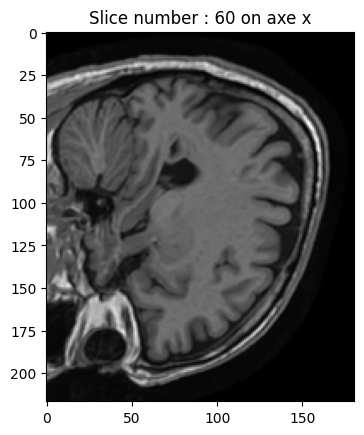

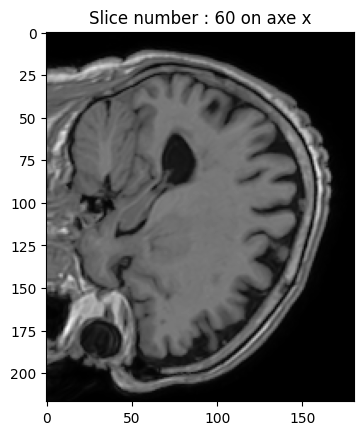

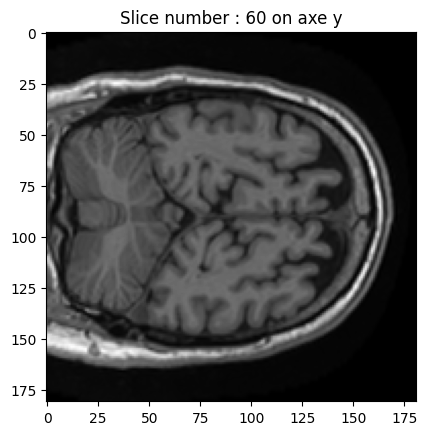

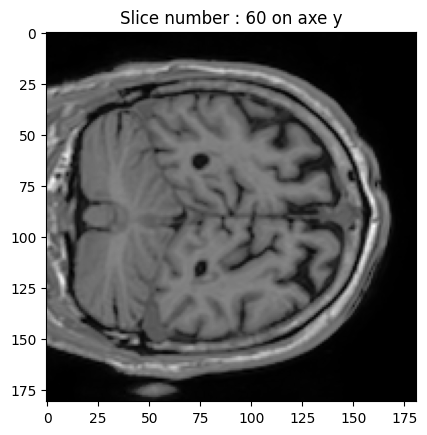

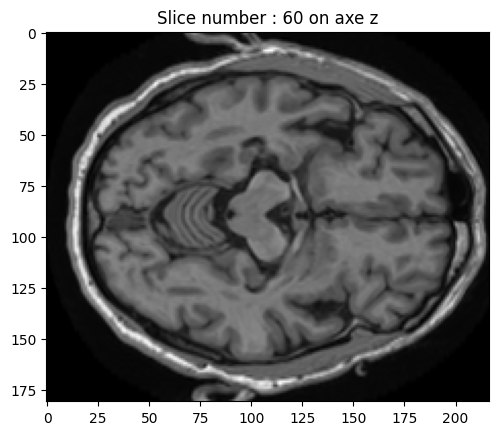

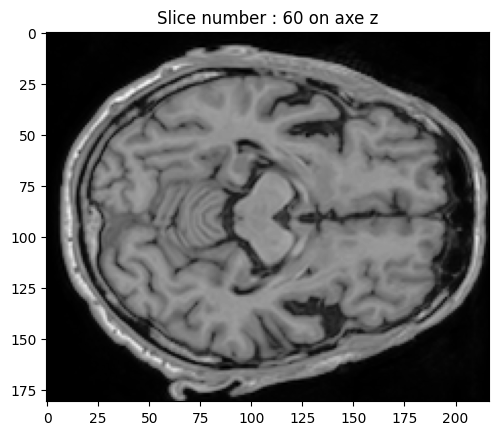

In [9]:
# MRI images are composed by many slices, build a montage of the them
def show_2D(irm, slice, axe):
    if axe == "x":
        plt.imshow(irm[slice,:,:], cmap="gray")
    elif axe == "y":
        plt.imshow(irm[:,slice,:], cmap="gray")
    elif axe == "z":
        plt.imshow(irm[:,:,slice], cmap="gray")
    plt.title("Slice number : " + str(slice) + " on axe " + axe)
    plt.show()

firstAug = int(train_set.__len__()/2)
img = nib.load(train_set[0])
print(firstAug)
img2 = nib.load(train_set[firstAug])

show_2D(img.get_fdata(), 60, "x")
show_2D(img2.get_fdata(), 60, "x")

show_2D(img.get_fdata(), 60, "y")
show_2D(img2.get_fdata(), 60, "y")

show_2D(img.get_fdata(), 60, "z")
show_2D(img2.get_fdata(), 60, "z")

Imbalanced Data

{'CN': 227, 'SMCI': 129, 'PMCI': 171, 'AD': 191}


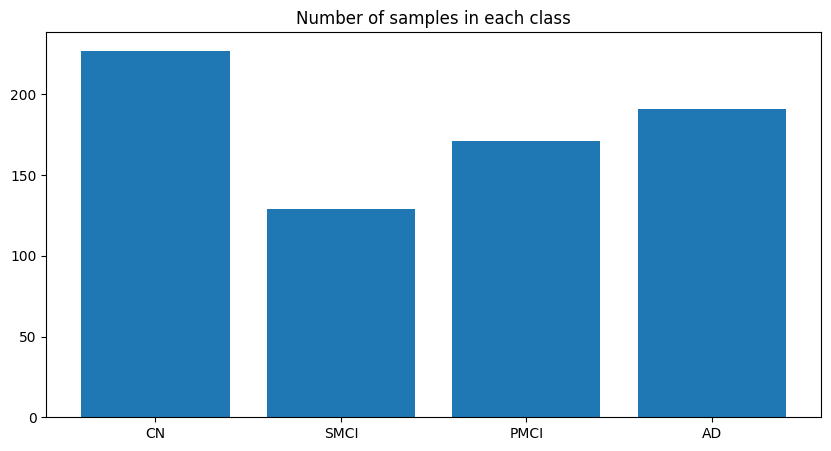

In [10]:
## Calculate number of samples in each class.
input_folder = 'lib'
class_counts = dict()
class_names = ["CN", "SMCI", "PMCI", "AD"]
if nb_classes == 2:
    class_names = ["CN", "AD"]
for folder in class_names:
    class_counts[folder] = len(os.listdir(input_folder+'/'+folder))

print(class_counts)

# plot the number of samples in each class
plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values())
plt.title('Number of samples in each class')
plt.show()

# 3D Convolutional Neural Network without data augmentation

In [11]:
from src.bi_classifier3D import Biclassifier3D

input_shape = (train_sequence[0][0].shape[1], train_sequence[0][0].shape[2], train_sequence[0][0].shape[3], train_sequence[0][0].shape[4])
print("Input shape:", input_shape)
bicl = Biclassifier3D(input_shape, n_classes=nb_classes, n_filters=8, kernel_size=3, activation='relu', dropout=0.4)
model = bicl.build_model()
model.summary()
# Compile model
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=1e-4),
    metrics=['accuracy'],
)

Input shape: (40, 40, 80, 1)


/home/prtissot/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 40, 40, 80, 1)]   0         
                                                                 
 conv3d (Conv3D)             (None, 40, 40, 80, 8)     224       
                                                                 
 batch_normalization (Batch  (None, 40, 40, 80, 8)     32        
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 40, 40, 80, 8)     0         
                                                                 
 conv3d_1 (Conv3D)           (None, 40, 40, 80, 8)     1736      
                                                                 
 activation_1 (Activation)   (None, 40, 40, 80, 8)     0         
                                                             

Model training

In [12]:
# checkpoint
filepath="classifier3D_test_lol-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=5, verbose=1)

callbacks_list = [checkpoint, early_stop, reduce_lr]

In [13]:
model.fit(
    train_sequence,
    validation_data=val_sequence,
    validation_steps=len(val_set) // batch_size,
    callbacks=callbacks_list,
    epochs=10,
)

Epoch 1/10


I0000 00:00:1702656262.261168   55178 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


36/36 [==============================] - ETA: 0s - loss: 1.4382 - accuracy: 0.2766
Epoch 1: val_accuracy improved from -inf to 0.22321, saving model to classifier3D_test_lol-01-0.22.hdf5
36/36 [==============================] - 102s 3s/step - loss: 1.4382 - accuracy: 0.2766 - val_loss: 1.3939 - val_accuracy: 0.2232 - lr: 1.0000e-04
Epoch 2/10


/home/prtissot/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


36/36 [==============================] - ETA: 0s - loss: 1.3309 - accuracy: 0.3812
Epoch 2: val_accuracy improved from 0.22321 to 0.37500, saving model to classifier3D_test_lol-02-0.38.hdf5
36/36 [==============================] - 91s 3s/step - loss: 1.3309 - accuracy: 0.3812 - val_loss: 1.2983 - val_accuracy: 0.3750 - lr: 1.0000e-04
Epoch 3/10
36/36 [==============================] - ETA: 0s - loss: 1.2316 - accuracy: 0.4273
Epoch 3: val_accuracy improved from 0.37500 to 0.38393, saving model to classifier3D_test_lol-03-0.38.hdf5
36/36 [==============================] - 94s 3s/step - loss: 1.2316 - accuracy: 0.4273 - val_loss: 1.2751 - val_accuracy: 0.3839 - lr: 1.0000e-04
Epoch 4/10
36/36 [==============================] - ETA: 0s - loss: 1.1387 - accuracy: 0.5248
Epoch 4: val_accuracy did not improve from 0.38393
36/36 [==============================] - 92s 3s/step - loss: 1.1387 - accuracy: 0.5248 - val_loss: 1.2523 - val_accuracy: 0.3839 - lr: 1.0000e-04
Epoch 5/10
36/36 [========

Visualizing Training History

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


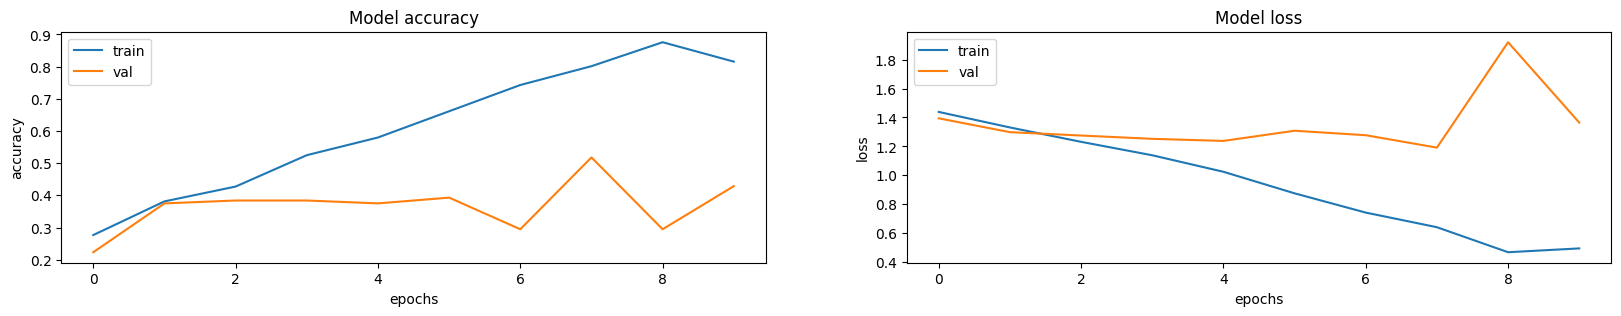

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

print(model.history.history.keys())
for i, metric in enumerate(['accuracy', 'loss']):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history[f'val_{metric}'])
    ax[i].set_title(f'Model {metric}')
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(metric)
    ax[i].legend(['train', 'val'])

Model Evaluation

In [15]:
# test_sequence = NiiSequence(test_set, batch_size, nb_classes=nb_classes, mode="HC", shuffle=False)
model.evaluate(test_sequence, verbose=1)

10/10 [==============================] - 20s 2s/step - loss: 1.5504 - accuracy: 0.4384


[1.5504103899002075, 0.4383561611175537]

In [16]:
y = model.predict(test_sequence)

10/10 [==============================] - 20s 2s/step


In [17]:
y_pred = y.argmax(axis=1)
y_test = np.array(test_labels)
print(y_pred)
print(y_test)

[1 0 0 1 0 0 3 1 1 1 0 0 0 0 1 0 1 1 3 1 1 0 1 3 3 0 0 0 1 0 1 0 0 0 1 3 0
 0 0 0 1 0 3 3 0 1 1 1 2 3 0 1 3 3 0 1 1 1 3 0 3 0 0 3 0 1 1 1 0 0 3 3 3 3
 3 3 3 3 3 1 3 0 0 3 3 3 3 3 3 3 3 3 3 3 1 3 3 0 1 3 3 3 3 3 3 0 3 3 0 3 3
 3 1 3 3 3 1 3 3 3 3 3 3 3 3 3 3 0 3 3 3 3 3 3 0 1 3 3 3 3 3 3 0 3 3 3]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


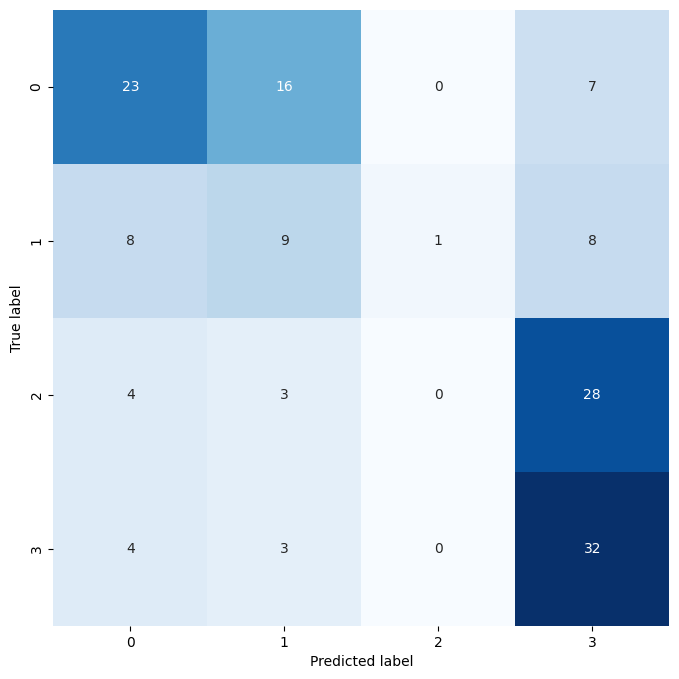

In [18]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
cm_ = cm / cm.astype(float).sum(axis=1) * 100
plt.figure(figsize=(8, 8))
sn.heatmap(cm, annot=True, square=True, cmap='Blues', cbar=False)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

36/36 [==============================] - 72s 2s/step


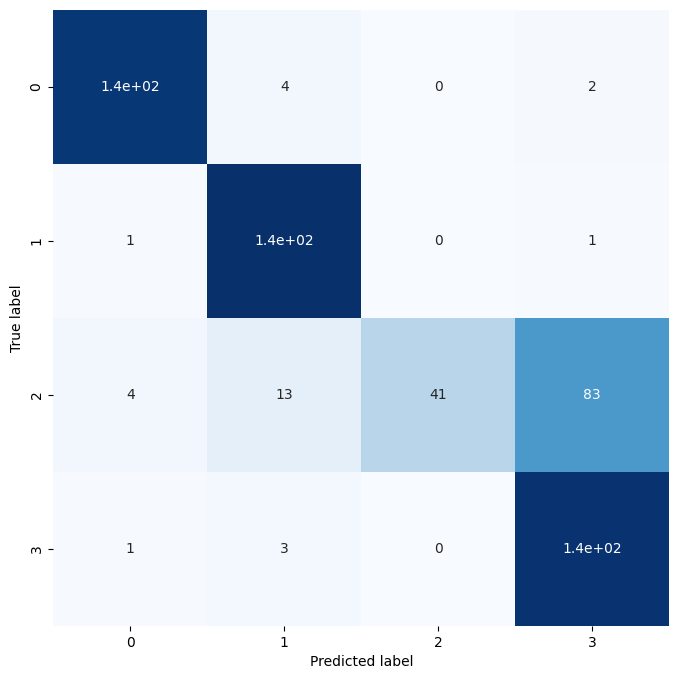

In [19]:
y = model.predict(train_sequence)
y_pred = y.argmax(axis=1)
y_train = np.array(train_labels)
# print(y_pred)
# print(y_train)

cm = confusion_matrix(y_train, y_pred)
cm_ = cm / cm.astype(float).sum(axis=1) * 100
plt.figure(figsize=(8, 8))
sn.heatmap(cm, annot=True, square=True, cmap='Blues', cbar=False)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Neural network with data augmentation

In [20]:
def fonc_training(train_sequence_aug):
    input_shape = (train_sequence[0][0].shape[1], train_sequence[0][0].shape[2], train_sequence[0][0].shape[3], train_sequence[0][0].shape[4])
    print("Input shape:", input_shape)
    bicl = Biclassifier3D(input_shape, n_classes=nb_classes, n_filters=8, kernel_size=3, activation='relu', dropout=0.4)
    model = bicl.build_model()
    model.summary()
    # Compile model
    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=1e-3),
        metrics=['accuracy'],
    )
    # checkpoint
    filepath="classifcier3D_test-dataAug-{epoch:02d}-{val_accuracy:.2f}.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    early_stop = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=5, verbose=1)
    callbacks_list = [checkpoint, early_stop]
    
    model.fit(
        train_sequence_aug,
        validation_data=val_sequence,
        validation_steps=len(val_set) // batch_size,
        callbacks=callbacks_list,
        epochs=20,
    )
    
    fig, ax = plt.subplots(1, 2, figsize=(20, 3))
    ax = ax.ravel()
    
    print(model.history.history.keys())
    for i, metric in enumerate(['accuracy', 'loss']):
        ax[i].plot(model.history.history[metric])
        ax[i].plot(model.history.history[f'val_{metric}'])
        ax[i].set_title(f'Model {metric}')
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(metric)
        ax[i].legend(['train', 'val'])

    return model

In [21]:
def fonc_eval(model):
    model.evaluate(test_sequence, verbose=1)
    
    y = model.predict(test_sequence)
    y_pred = y.argmax(axis=1)
    y_test = np.array(test_labels)
    print(y_pred)
    print(y_test)
    
    cm = confusion_matrix(y_test, y_pred)
    cm_ = cm / cm.astype(float).sum(axis=1) * 100
    plt.figure(figsize=(8, 8))
    sn.heatmap(cm, annot=True, square=True, cmap='Blues', cbar=False)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

In [22]:
def fonc_predict_train(model):
    y = model.predict(train_sequence)
    y_pred = y.argmax(axis=1)
    y_train = np.array(train_labels)
    # print(y_pred)
    # print(y_train)
    
    cm = confusion_matrix(y_train, y_pred)
    cm_ = cm / cm.astype(float).sum(axis=1) * 100
    plt.figure(figsize=(8, 8))
    sn.heatmap(cm, annot=True, square=True, cmap='Blues', cbar=False)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

### Gaussian offset

In [23]:
train_sequence_aug = NiiSequence(train_set, batch_size, nb_classes=nb_classes, mode="HC",shuffle=False, data_aug=['gaussian_offset'])

In [24]:
print("Shape of one MRI element:", train_sequence_aug[0][0].shape)
print("Train label example after loading:", train_sequence_aug[0][1].shape)

Shape of one MRI element: (16, 40, 40, 80, 1)
Train label example after loading: (16, 4)


Input shape: (40, 40, 80, 1)
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 40, 40, 80, 1)]   0         
                                                                 
 conv3d_4 (Conv3D)           (None, 40, 40, 80, 8)     224       
                                                                 
 batch_normalization_1 (Bat  (None, 40, 40, 80, 8)     32        
 chNormalization)                                                
                                                                 
 activation_6 (Activation)   (None, 40, 40, 80, 8)     0         
                                                                 
 conv3d_5 (Conv3D)           (None, 40, 40, 80, 8)     1736      
                                                                 
 activation_7 (Activation)   (None, 40, 40, 80, 8)     0         
                              

/home/prtissot/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Epoch 1/20
71/71 [==============================] - ETA: 0s - loss: 1.6888 - accuracy: 0.2385
Epoch 1: val_accuracy improved from -inf to 0.34821, saving model to classifcier3D_test-dataAug-01-0.35.hdf5
71/71 [==============================] - 86s 1s/step - loss: 1.6888 - accuracy: 0.2385 - val_loss: 1.3858 - val_accuracy: 0.3482
Epoch 2/20


/home/prtissot/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


71/71 [==============================] - ETA: 0s - loss: 1.3866 - accuracy: 0.2332
Epoch 2: val_accuracy did not improve from 0.34821
71/71 [==============================] - 85s 1s/step - loss: 1.3866 - accuracy: 0.2332 - val_loss: 1.3853 - val_accuracy: 0.2500
Epoch 3/20
71/71 [==============================] - ETA: 0s - loss: 1.3853 - accuracy: 0.2739
Epoch 3: val_accuracy improved from 0.34821 to 0.40179, saving model to classifcier3D_test-dataAug-03-0.40.hdf5
71/71 [==============================] - 88s 1s/step - loss: 1.3853 - accuracy: 0.2739 - val_loss: 1.3796 - val_accuracy: 0.4018
Epoch 4/20
71/71 [==============================] - ETA: 0s - loss: 1.3838 - accuracy: 0.2615
Epoch 4: val_accuracy did not improve from 0.40179
71/71 [==============================] - 88s 1s/step - loss: 1.3838 - accuracy: 0.2615 - val_loss: 1.3624 - val_accuracy: 0.3482
Epoch 5/20
71/71 [==============================] - ETA: 0s - loss: 1.3699 - accuracy: 0.3218
Epoch 5: val_accuracy improved fro

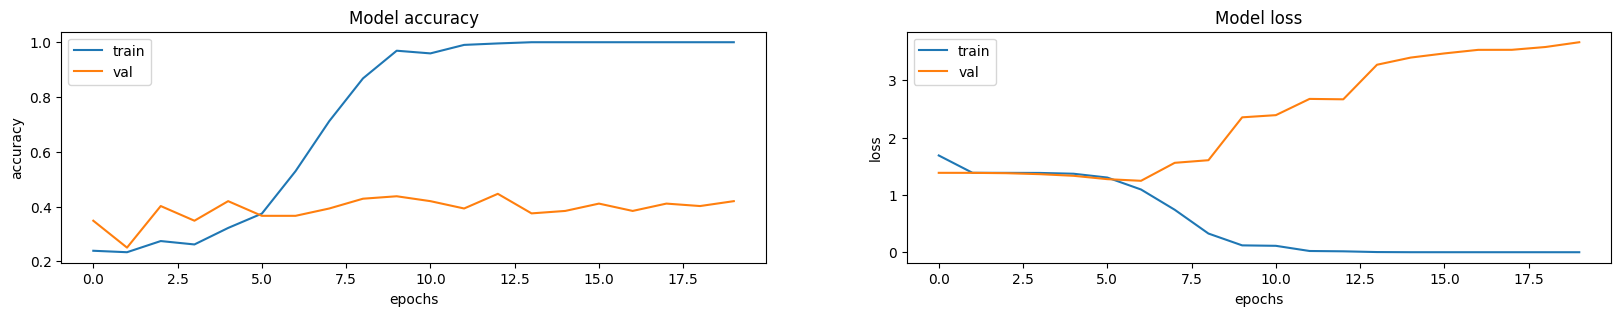

In [25]:
model =fonc_training(train_sequence_aug)

10/10 [==============================] - 19s 2s/step
[0 2 2 1 0 0 2 0 1 0 0 0 0 0 0 0 3 1 2 1 1 0 2 3 2 0 0 1 1 2 0 0 0 0 1 2 0
 1 2 0 1 2 0 2 0 0 2 2 2 0 0 1 1 2 0 1 2 1 2 0 2 1 0 2 2 2 1 3 2 0 3 3 1 2
 0 1 2 2 2 2 2 0 0 3 2 3 2 2 3 2 2 3 3 0 1 3 2 0 3 3 2 3 3 0 0 0 2 2 0 3 3
 3 1 0 2 2 2 3 2 2 2 1 3 3 3 3 2 0 0 2 2 3 2 2 2 2 2 3 3 2 3 3 0 3 3 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


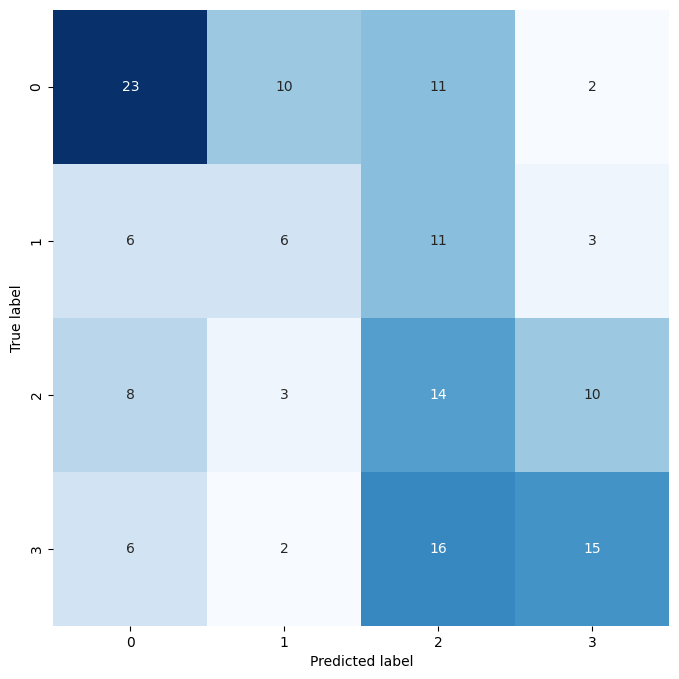

In [26]:
fonc_eval(model)

36/36 [==============================] - 66s 2s/step


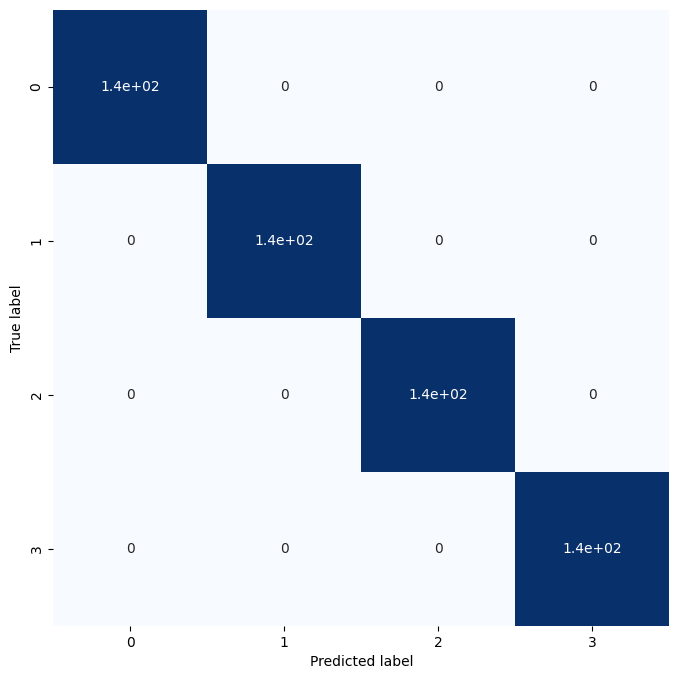

In [27]:
fonc_predict_train(model)

### Gaussian noise

In [28]:
train_sequence_aug = NiiSequence(train_set, batch_size, nb_classes=nb_classes, mode="HC",shuffle=False, data_aug=['gaussian_noise'])

In [29]:
print("Shape of one MRI element:", train_sequence_aug[0][0].shape)
print("Train label example after loading:", train_sequence_aug[0][1].shape)

Shape of one MRI element: (16, 40, 40, 80, 1)
Train label example after loading: (16, 4)


Input shape: (40, 40, 80, 1)
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 40, 40, 80, 1)]   0         
                                                                 
 conv3d_8 (Conv3D)           (None, 40, 40, 80, 8)     224       
                                                                 
 batch_normalization_2 (Bat  (None, 40, 40, 80, 8)     32        
 chNormalization)                                                
                                                                 
 activation_12 (Activation)  (None, 40, 40, 80, 8)     0         
                                                                 
 conv3d_9 (Conv3D)           (None, 40, 40, 80, 8)     1736      
                                                                 
 activation_13 (Activation)  (None, 40, 40, 80, 8)     0         
                              

/home/prtissot/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Epoch 1/20
71/71 [==============================] - ETA: 0s - loss: 1.7009 - accuracy: 0.2287
Epoch 1: val_accuracy improved from -inf to 0.21429, saving model to classifcier3D_test-dataAug-01-0.21.hdf5
71/71 [==============================] - 90s 1s/step - loss: 1.7009 - accuracy: 0.2287 - val_loss: 1.3880 - val_accuracy: 0.2143
Epoch 2/20


/home/prtissot/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


71/71 [==============================] - ETA: 0s - loss: 1.3866 - accuracy: 0.2420
Epoch 2: val_accuracy improved from 0.21429 to 0.30357, saving model to classifcier3D_test-dataAug-02-0.30.hdf5
71/71 [==============================] - 86s 1s/step - loss: 1.3866 - accuracy: 0.2420 - val_loss: 1.3872 - val_accuracy: 0.3036
Epoch 3/20
71/71 [==============================] - ETA: 0s - loss: 1.3707 - accuracy: 0.3112
Epoch 3: val_accuracy improved from 0.30357 to 0.34821, saving model to classifcier3D_test-dataAug-03-0.35.hdf5
71/71 [==============================] - 86s 1s/step - loss: 1.3707 - accuracy: 0.3112 - val_loss: 1.3677 - val_accuracy: 0.3482
Epoch 4/20
71/71 [==============================] - ETA: 0s - loss: 1.3346 - accuracy: 0.3528
Epoch 4: val_accuracy improved from 0.34821 to 0.38393, saving model to classifcier3D_test-dataAug-04-0.38.hdf5
71/71 [==============================] - 87s 1s/step - loss: 1.3346 - accuracy: 0.3528 - val_loss: 1.3338 - val_accuracy: 0.3839
Epoch 

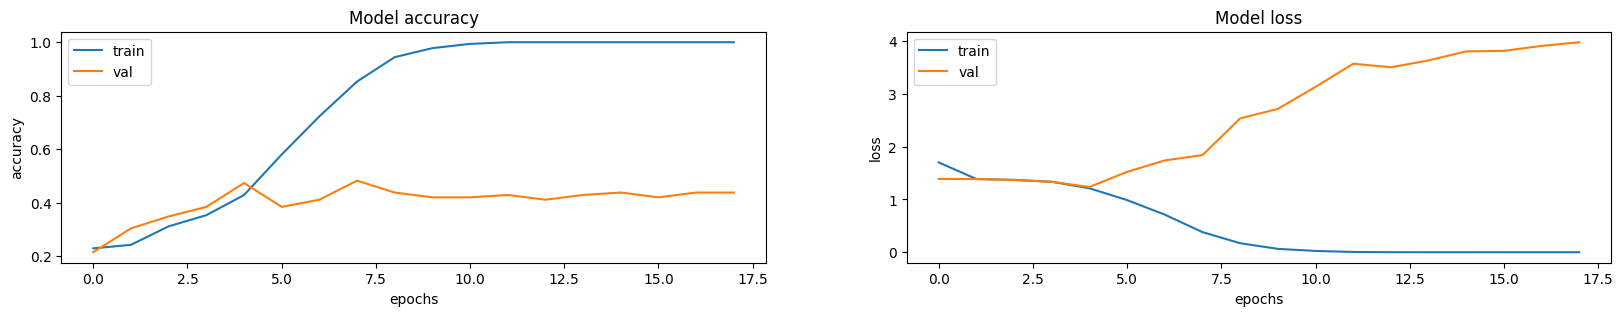

In [30]:
model =fonc_training(train_sequence_aug)

10/10 [==============================] - 18s 2s/step
[1 2 1 0 0 0 2 1 1 1 0 0 0 0 2 0 2 1 2 0 2 0 1 3 2 0 0 0 1 0 2 2 0 0 1 3 0
 0 1 0 1 0 2 3 0 0 2 0 3 2 0 0 1 3 0 0 2 1 2 0 3 0 0 2 1 2 3 2 0 0 3 3 3 2
 2 3 2 2 0 2 3 0 0 2 1 2 1 3 3 3 2 3 3 3 2 3 3 3 3 1 2 3 3 0 2 1 0 1 2 3 3
 3 1 0 3 2 2 3 3 2 2 3 3 2 3 3 0 0 0 1 2 3 0 2 0 0 2 3 3 3 3 3 2 2 3 2]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


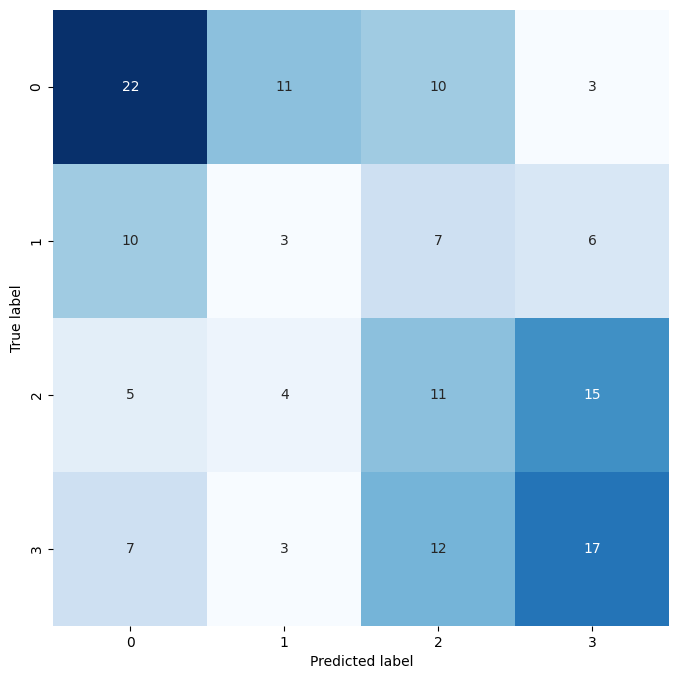

In [31]:
fonc_eval(model)

36/36 [==============================] - 73s 2s/step


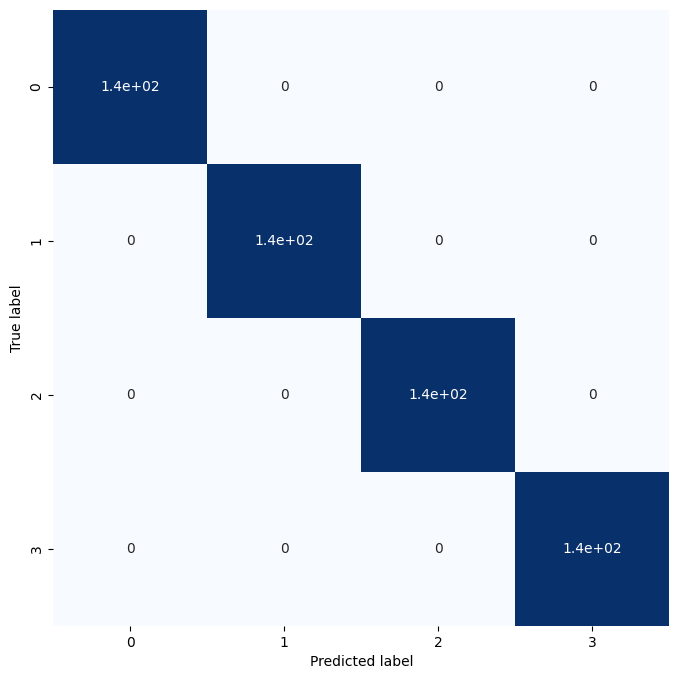

In [32]:
fonc_predict_train(model)

### Shift intensity

In [33]:
train_sequence_aug = NiiSequence(train_set, batch_size, nb_classes=nb_classes, mode="HC",shuffle=False, data_aug=['shiftIntensity'])

In [34]:
print("Shape of one MRI element:", train_sequence_aug[0][0].shape)
print("Train label example after loading:", train_sequence_aug[0][1].shape)

Shape of one MRI element: (16, 40, 40, 80, 1)
Train label example after loading: (16, 4)


Input shape: (40, 40, 80, 1)
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 40, 40, 80, 1)]   0         
                                                                 
 conv3d_12 (Conv3D)          (None, 40, 40, 80, 8)     224       
                                                                 
 batch_normalization_3 (Bat  (None, 40, 40, 80, 8)     32        
 chNormalization)                                                
                                                                 
 activation_18 (Activation)  (None, 40, 40, 80, 8)     0         
                                                                 
 conv3d_13 (Conv3D)          (None, 40, 40, 80, 8)     1736      
                                                                 
 activation_19 (Activation)  (None, 40, 40, 80, 8)     0         
                              

/home/prtissot/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Epoch 1/20
71/71 [==============================] - ETA: 0s - loss: 1.4330 - accuracy: 0.2730
Epoch 1: val_accuracy improved from -inf to 0.39286, saving model to classifcier3D_test-dataAug-01-0.39.hdf5
71/71 [==============================] - 91s 1s/step - loss: 1.4330 - accuracy: 0.2730 - val_loss: 1.3714 - val_accuracy: 0.3929
Epoch 2/20


/home/prtissot/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


71/71 [==============================] - ETA: 0s - loss: 1.3078 - accuracy: 0.3848
Epoch 2: val_accuracy improved from 0.39286 to 0.41071, saving model to classifcier3D_test-dataAug-02-0.41.hdf5
71/71 [==============================] - 85s 1s/step - loss: 1.3078 - accuracy: 0.3848 - val_loss: 1.2874 - val_accuracy: 0.4107
Epoch 3/20
71/71 [==============================] - ETA: 0s - loss: 1.1674 - accuracy: 0.4716
Epoch 3: val_accuracy did not improve from 0.41071
71/71 [==============================] - 88s 1s/step - loss: 1.1674 - accuracy: 0.4716 - val_loss: 1.3741 - val_accuracy: 0.3571
Epoch 4/20
71/71 [==============================] - ETA: 0s - loss: 0.8413 - accuracy: 0.6649
Epoch 4: val_accuracy did not improve from 0.41071
71/71 [==============================] - 85s 1s/step - loss: 0.8413 - accuracy: 0.6649 - val_loss: 1.7271 - val_accuracy: 0.3571
Epoch 5/20
71/71 [==============================] - ETA: 0s - loss: 0.4794 - accuracy: 0.8094
Epoch 5: val_accuracy did not impr

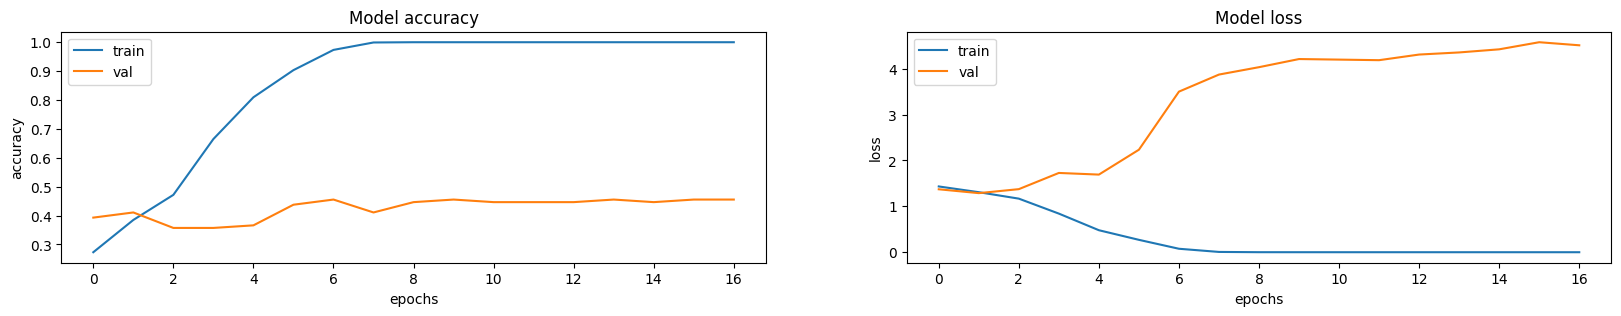

In [35]:
model =fonc_training(train_sequence_aug)

10/10 [==============================] - 19s 2s/step
[0 0 0 0 0 0 2 2 1 0 1 0 0 0 0 0 2 1 2 1 0 0 1 3 2 0 0 0 1 0 0 0 0 0 0 3 0
 1 1 0 1 0 0 0 0 0 2 2 2 0 0 0 3 0 0 0 2 1 2 0 2 0 0 3 0 2 3 2 2 0 3 3 3 2
 2 3 0 2 3 2 2 0 1 3 3 2 3 3 3 3 2 3 3 3 1 3 3 0 2 3 1 3 3 0 3 0 0 1 2 2 3
 2 1 2 3 2 3 3 3 2 2 3 2 2 3 3 2 0 0 1 2 3 3 3 0 0 2 3 3 2 3 3 0 2 3 2]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


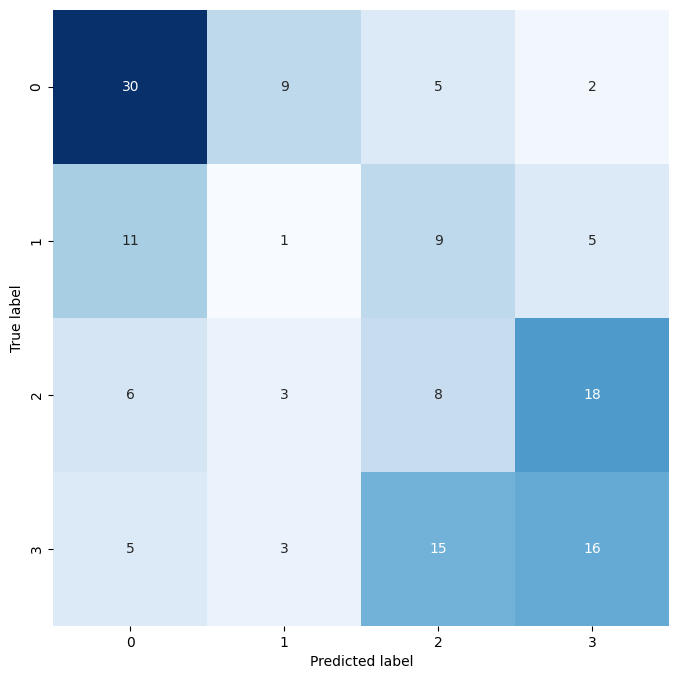

In [36]:
fonc_eval(model)

36/36 [==============================] - 73s 2s/step


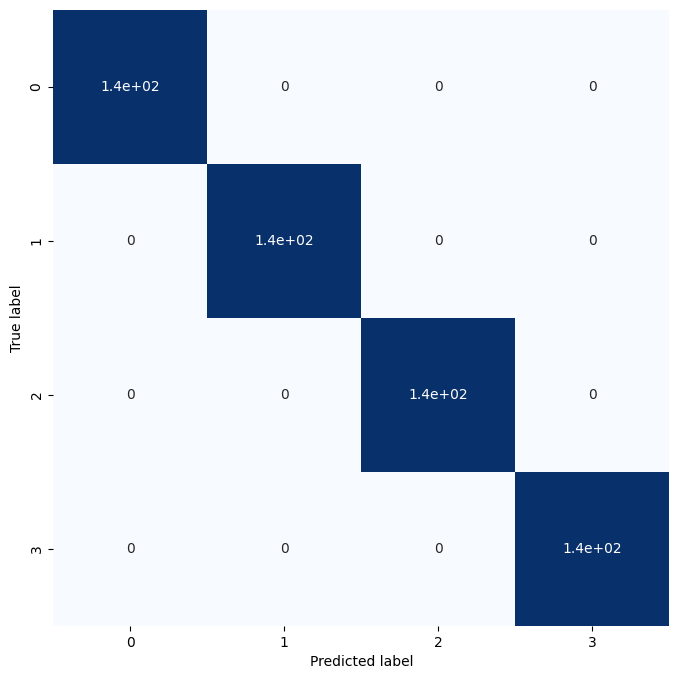

In [37]:
fonc_predict_train(model)

### Adjuste contrast

In [38]:
train_sequence_aug = NiiSequence(train_set, batch_size, nb_classes=nb_classes, mode="HC",shuffle=False, data_aug=['adjustContrast'])

In [39]:
print("Shape of one MRI element:", train_sequence_aug[0][0].shape)
print("Train label example after loading:", train_sequence_aug[0][1].shape)

Shape of one MRI element: (16, 40, 40, 80, 1)
Train label example after loading: (16, 4)


Input shape: (40, 40, 80, 1)
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 40, 40, 80, 1)]   0         
                                                                 
 conv3d_16 (Conv3D)          (None, 40, 40, 80, 8)     224       
                                                                 
 batch_normalization_4 (Bat  (None, 40, 40, 80, 8)     32        
 chNormalization)                                                
                                                                 
 activation_24 (Activation)  (None, 40, 40, 80, 8)     0         
                                                                 
 conv3d_17 (Conv3D)          (None, 40, 40, 80, 8)     1736      
                                                                 
 activation_25 (Activation)  (None, 40, 40, 80, 8)     0         
                              

/home/prtissot/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Epoch 1/20
71/71 [==============================] - ETA: 0s - loss: 1.5259 - accuracy: 0.2527
Epoch 1: val_accuracy improved from -inf to 0.30357, saving model to classifcier3D_test-dataAug-01-0.30.hdf5
71/71 [==============================] - 89s 1s/step - loss: 1.5259 - accuracy: 0.2527 - val_loss: 1.3935 - val_accuracy: 0.3036
Epoch 2/20


/home/prtissot/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


71/71 [==============================] - ETA: 0s - loss: 1.3839 - accuracy: 0.2943
Epoch 2: val_accuracy did not improve from 0.30357
71/71 [==============================] - 88s 1s/step - loss: 1.3839 - accuracy: 0.2943 - val_loss: 1.3888 - val_accuracy: 0.1875
Epoch 3/20
71/71 [==============================] - ETA: 0s - loss: 1.3513 - accuracy: 0.3085
Epoch 3: val_accuracy did not improve from 0.30357
71/71 [==============================] - 85s 1s/step - loss: 1.3513 - accuracy: 0.3085 - val_loss: 1.3772 - val_accuracy: 0.2143
Epoch 4/20
71/71 [==============================] - ETA: 0s - loss: 1.3012 - accuracy: 0.3750
Epoch 4: val_accuracy improved from 0.30357 to 0.42857, saving model to classifcier3D_test-dataAug-04-0.43.hdf5
71/71 [==============================] - 86s 1s/step - loss: 1.3012 - accuracy: 0.3750 - val_loss: 1.2680 - val_accuracy: 0.4286
Epoch 5/20
71/71 [==============================] - ETA: 0s - loss: 1.1916 - accuracy: 0.4637
Epoch 5: val_accuracy improved fro

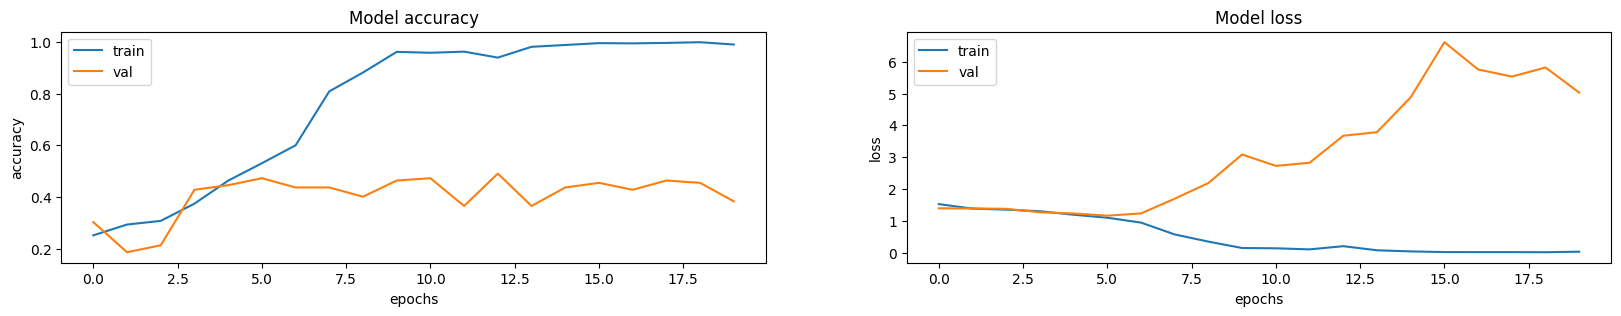

In [40]:
model =fonc_training(train_sequence_aug)

10/10 [==============================] - 18s 2s/step
[1 0 2 1 2 0 2 2 1 1 1 0 0 0 1 0 2 1 2 1 1 1 1 3 1 0 1 1 1 2 1 0 1 0 1 2 2
 1 1 2 1 0 2 2 0 1 1 2 2 2 2 2 3 3 0 1 1 1 2 2 3 1 1 2 1 1 0 1 2 2 3 3 1 2
 1 3 1 3 2 2 2 2 0 2 1 2 2 2 2 1 2 3 3 3 1 3 3 0 1 3 1 3 3 2 1 2 2 2 1 3 3
 2 1 2 3 2 1 3 3 2 2 3 3 1 3 3 2 0 2 3 2 3 1 3 0 2 2 3 2 3 3 3 1 2 3 2]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


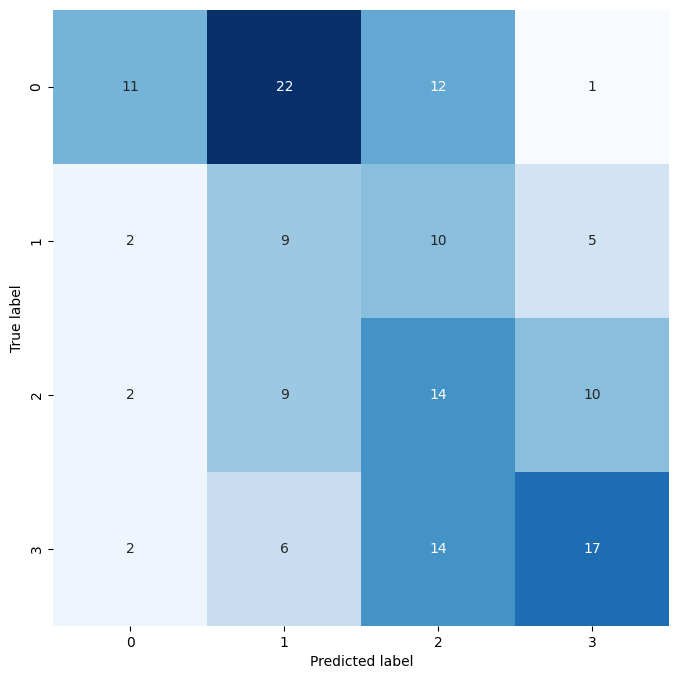

In [41]:
fonc_eval(model)

36/36 [==============================] - 71s 2s/step


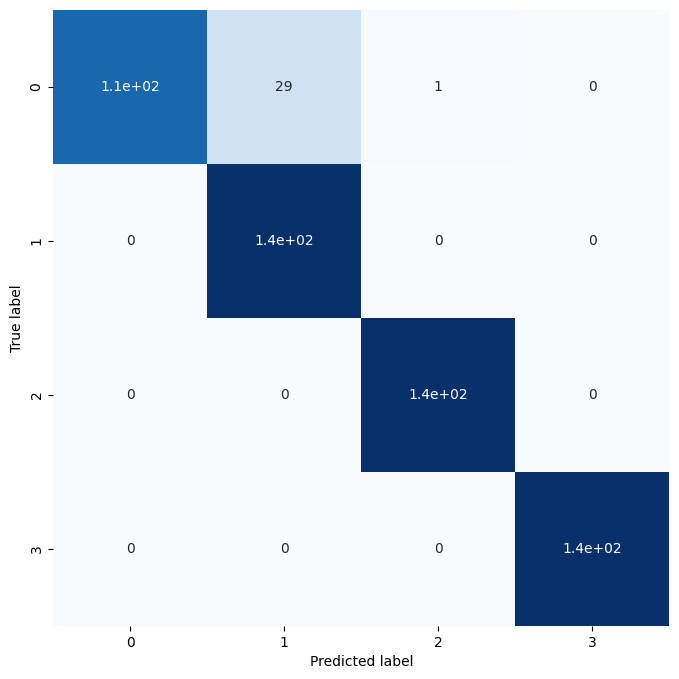

In [42]:
fonc_predict_train(model)

### RandBiasField

In [43]:
train_sequence_aug = NiiSequence(train_set, batch_size, nb_classes=nb_classes, mode="HC",shuffle=False, data_aug=['randBiasField'])

In [44]:
print("Shape of one MRI element:", train_sequence_aug[0][0].shape)
print("Train label example after loading:", train_sequence_aug[0][1].shape)

Shape of one MRI element: (16, 40, 40, 80, 1)
Train label example after loading: (16, 4)


Input shape: (40, 40, 80, 1)
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 40, 40, 80, 1)]   0         
                                                                 
 conv3d_20 (Conv3D)          (None, 40, 40, 80, 8)     224       
                                                                 
 batch_normalization_5 (Bat  (None, 40, 40, 80, 8)     32        
 chNormalization)                                                
                                                                 
 activation_30 (Activation)  (None, 40, 40, 80, 8)     0         
                                                                 
 conv3d_21 (Conv3D)          (None, 40, 40, 80, 8)     1736      
                                                                 
 activation_31 (Activation)  (None, 40, 40, 80, 8)     0         
                              

/home/prtissot/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Epoch 1/20
71/71 [==============================] - ETA: 0s - loss: 1.5257 - accuracy: 0.3014
Epoch 1: val_accuracy improved from -inf to 0.38393, saving model to classifcier3D_test-dataAug-01-0.38.hdf5
71/71 [==============================] - 88s 1s/step - loss: 1.5257 - accuracy: 0.3014 - val_loss: 1.3620 - val_accuracy: 0.3839
Epoch 2/20


/home/prtissot/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


71/71 [==============================] - ETA: 0s - loss: 1.2672 - accuracy: 0.4016
Epoch 2: val_accuracy did not improve from 0.38393
71/71 [==============================] - 84s 1s/step - loss: 1.2672 - accuracy: 0.4016 - val_loss: 1.4276 - val_accuracy: 0.2857
Epoch 3/20
71/71 [==============================] - ETA: 0s - loss: 1.1080 - accuracy: 0.5062
Epoch 3: val_accuracy did not improve from 0.38393
71/71 [==============================] - 84s 1s/step - loss: 1.1080 - accuracy: 0.5062 - val_loss: 1.3081 - val_accuracy: 0.3750
Epoch 4/20
71/71 [==============================] - ETA: 0s - loss: 0.8211 - accuracy: 0.6649
Epoch 4: val_accuracy improved from 0.38393 to 0.45536, saving model to classifcier3D_test-dataAug-04-0.46.hdf5
71/71 [==============================] - 83s 1s/step - loss: 0.8211 - accuracy: 0.6649 - val_loss: 1.2812 - val_accuracy: 0.4554
Epoch 5/20
71/71 [==============================] - ETA: 0s - loss: 0.4704 - accuracy: 0.8307
Epoch 5: val_accuracy did not impr

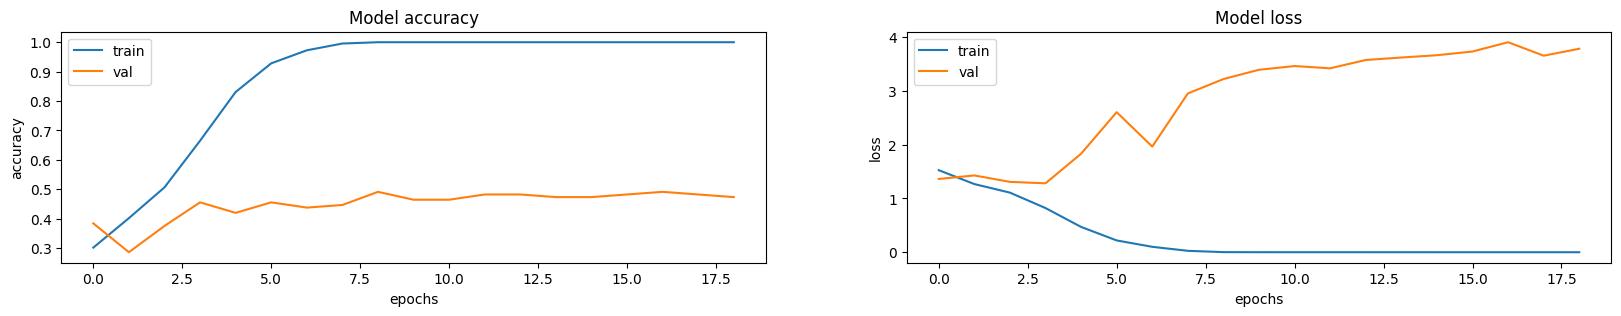

In [45]:
model =fonc_training(train_sequence_aug)

10/10 [==============================] - 19s 2s/step
[1 0 0 1 0 0 0 1 1 3 0 0 0 0 1 0 2 1 2 1 1 0 1 3 0 0 0 0 1 0 0 0 0 0 1 2 0
 0 0 0 1 0 0 0 0 0 1 2 2 2 0 2 3 3 0 0 0 2 2 0 3 0 0 2 0 2 3 2 2 2 3 3 1 2
 3 3 2 3 2 1 2 0 0 2 1 2 2 2 3 3 2 3 3 3 0 3 3 0 3 0 1 3 3 2 3 0 0 0 2 1 3
 3 2 2 3 2 2 3 3 2 3 3 3 2 3 3 0 0 0 2 2 3 2 3 2 0 2 3 2 2 3 3 0 2 2 2]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


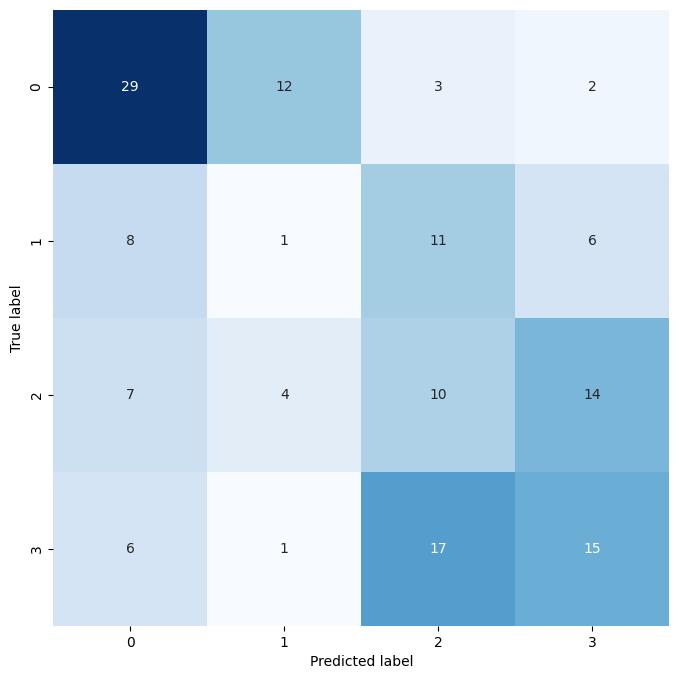

In [46]:
fonc_eval(model)

36/36 [==============================] - 71s 2s/step


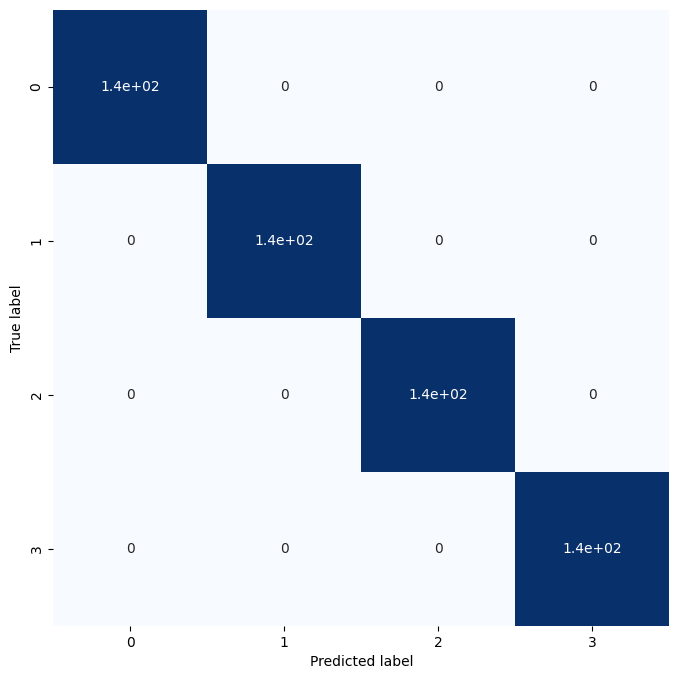

In [47]:
fonc_predict_train(model)

### rand3DElastic

In [14]:
train_sequence_aug = NiiSequence(train_set, batch_size, nb_classes=nb_classes, mode="HC",shuffle=False, data_aug=['rand3DElastic'])

In [15]:
print("Shape of one MRI element:", train_sequence_aug[0][0].shape)
print("Train label example after loading:", train_sequence_aug[0][1].shape)

Shape of one MRI element: (16, 40, 40, 80, 1)
Train label example after loading: (16, 4)


In [ ]:
model =fonc_training(train_sequence_aug)

Input shape: (40, 40, 80, 1)


/home/prtissot/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 40, 40, 80, 1)]   0         
                                                                 
 conv3d (Conv3D)             (None, 40, 40, 80, 8)     224       
                                                                 
 batch_normalization (Batch  (None, 40, 40, 80, 8)     32        
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 40, 40, 80, 8)     0         
                                                                 
 conv3d_1 (Conv3D)           (None, 40, 40, 80, 8)     1736      
                                                                 
 activation_1 (Activation)   (None, 40, 40, 80, 8)     0         
                                                             

I0000 00:00:1702654314.916805   52512 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


12/71 [====>.........................] - ETA: 2:35:59 - loss: 2.0620 - accuracy: 0.2812

In [ ]:
fonc_eval(model)

In [ ]:
fonc_predict_train(model)